In [1]:
import numpy as np
from scipy import sparse
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from math import sqrt
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import random
import gudhi
import os
import pickle

In [2]:
class neuron():
    """
    A `neuron` object. This class is the building blocks of the `Geometric_Brain_Network`. This class is designed
    in a way that each `neuron` can be given special intrinsic properties, instead of global rules. This 
    distinction enables to model neurons that are differing in functionality and to include heterogeneity in 
    the complex spreads we run on the networks compounded by them.
    
    Attributes
    ================
    
    neuron.id: int
        The id of a neuron.
        
    neuron.state: int
        The state of a neuron which is either on (1), off (0) or rest (-1). 
        
        If a neuron is on (1) at a given time step, it is going to contribute to it's neighbors' activation 
        who are inactive(0). If a neuron is off (0), it is ready to take input from it's active neighbors(1) i.e.
        it is ready to fire. If a neuron is resting (-1), it is neither contributing to it's neighbors' activation
        or it is able to receive input from it's active neighbors.
        
    neuron.memory: int
        Number of time points that the neuron is going to stay on (1) once it's activated i.e how long a neuron
        is going to remember it's activation enabling us modeling higher order Markov processes. Default is 0.
        
        A neuron with 'bad memory', memory of length 0, can not remember it's past, it can only remember the 
        current state. A neuron with memory of length 1, can remember it's activation for only 1 step in addition
        to the step where it is active total of two steps of activation. A neuron with 'full memory' remembers 
        it's activation throughout the whole experiment i.e. once it's activated it never gets deactivated. 
        
    neuron.rest: int
        Number of time points that the neuron is going to stay off (0) once it's dectivated i.e. refractory 
        period. Default is 0. 
        
        Inspired by the neurons in the nervous system, every `neuron` will have a resting period that is 
        relatively longer than the action potentials. So, once a neuron comes to the end of it's memory, it is 
        going to rest for some amount of time i.e. it will not be able to contribute to the system or it will not 
        be able to recieve inputs from it's neighbors. An 'energetic neuron'(or a 'restless neuron'), `neuron` with 
        rest 0, never pauses and it is either on (1) or off(0) whereas a 'lazy neuron', `neuron` with rest > 0 
        pauses to receive input once it's deactivated rest many time steps.
        
    neuron.threshold: float, in [0,1]
        We determine if a neuron is going to fire or not according to a simple rule: if the difference between
        the ratio of its active neighbors to all neighbors is big enough than the `threshold`, it fires. 
        
        This value is intrinsic to every `neuron` and mainly determines firing patterns and frequencies of 
        neurons.
        
    neuron.history: list
        Every `neuron` keeps track of it's state per se throughout an experiment i.e. it's history. 
    """
    
    def __init__(self, name, state = False, memory = 0, rest = 0, threshold = 0.1):
        self.id = name
        self.state = state
        self.memory = memory
        self.rest = rest
        self.threshold = threshold
        
        self.refresh_history()
        
    def refresh_history(self):
        """
        Helper method to refresh the history of a neuron back to empty list. Neccessary for consecutive calls
        of the dynamics as in `make_distance_matrix`.
        """
        self.history = []
        
        
class Geometric_Brain_Network():
    """
    This class is the main object we run our contagions on. `Geometric_Brain_Netwok` object explicitly inputs
    the `neuron` objects. The topology of the network is one of the important features of the network. We chose 2
    and 3 dimensional compact manifolds as our fundamental network topology pool for now. The importance of 
    geometric networks is that the geometric degree is a global property instead of a local property, same with 
    non-geometric degree. So, the total degree of every node is GD + nGD.
    
    Attributes
    ===============
    Geometric_Brain_Network.N: int
        Number of nodes in the network.
        
    Geometric_Brain_Network.neurons: list
        A list of `neuron` objects. Length of the list should match with number the of the nodes. See 
        `Geometric_Brain_Network.get_neurons`.
        
    Geometric_Brain_Network.GD: int
        Geometric degree of a node. Geometric degree is the number of 'closest' nodes(in a euclidean distance 
        manner) to connect to a node. For `Ring` topology, it has to be an even number because close neighbors 
        are located both on the left and right from a node. It also
        
    Geometric_Brain_Network.nGD: int
        Non-geometric degree of a node. Non-geometric edges are randomly connected to a node that are 'distant'.
        The combination of these two types of edges enables to types of phenomenan to occur, wavefront 
        propagation(WFP) and appearance of new clusters(ANC).
        
    Geometric_Brain_Network.manifold: string
        The network topology that the nodes are sitting on. This type determines the manifold that the WFP is 
        going to follow. Also, the persistent homology of the first activation of the nodes during an experiment
        recovers this type of topology as well. 
        
        This can be 'Ring', that is the only compact 1D-manifold, 'Sphere' and 'Torus', only compact 2D-manifolds,
        for now. In the case of 'Sphere' and 'Torus', `geometric_degree` is not possible to be distributed
        uniformly among nodes, so some nodes may have slightly higher GD in these options but on average, 
        geometric degree is going to be close to GD which you can see using `self.text`. Also, in the case of '
        Torus', because of the parametrization we use, the initial number of nodes should be a square.
        
    Geometric_Brain_Network.A: sparse matrix
        The adjacency matrix of the network keeping track of the neighborhood information.
        
    Geometric_Brain_Network.time: int
        Initialized from 0, see `get_neurons`. When we run a contagion on the network time will be iterated 
        accordingly.
    
    Geometric_Brain_Network.text: str
        A handy summary of the network for figures and whatnot.
    
    """
    
    def __init__(self, size, geometric_degree = 1, nongeometric_degree = 0, manifold = 'Ring'):
        
        self.N = size  
        self.GD = geometric_degree
        self.nGD = nongeometric_degree
        self.A = sparse.lil_matrix(((self.N, self.N)), dtype = bool)
        self.manifold = manifold
        self.text = '%s Network on %d nodes'%(self.manifold, self.N)
        
        self.make_geometric()
        if self.nGD > 0: self.add_noise_to_geometric()
            
    def get_neurons(self, neurons):
        """
        Method to append the `neuron` objects into the network. We don't initialize the network with neurons in 
        case we need to use the same network for different neuronal properties because we don't have control over 
        the randomly added non-geometric edges in the work. So, we can just add a new set of neurons to the 
        network by using this method.
        
        Parameters
        ===========
        neurons: list
            A list of `neuron` objects of length `self.N`. 
        """
        if self.N != len(neurons): 
            raise InputError('Number of neurons provided should be size %d'%self.N)
        else:
            self.nodes = neurons
        
    def make_geometric(self):
        """
        Method that is called automatically during initialization. Creates a `self.manifold` type of topology 
        based on the geometric degree and size.
        """
        
        if self.manifold == 'Ring':
            
            if self.GD >= int(self.N)-1: 
                raise InputError('Geometric Degree cannot exceed the half of the size of the network.')
            elif self.GD<1 or self.GD%2 == 1:
                raise InputError('Geometric Degree should be an even positive integer.')
            
            GD = int(self.GD/2)
            for u in range(self.N):
                for i in range(1, GD + 1):
                    #from left
                    if u + i >= self.N: 
                        v = u + i - self.N
                    else: v = u + i
                    self.A[u,v] = True
                    #from right
                    if u - i < 0: 
                        v = self.N + u - i
                    else: v = u - i
                    self.A[u,v] = True
            self.text = self.text + ' w/ GD %d'%(self.GD)
            
        elif self.manifold == 'Sphere': 
            ## We use the method called 'Golden Spiral' to evenly distribute n points on a sphere.
            
            indices = np.arange(0, self.N, dtype=float) + 0.5

            phi = np.arccos(1 - 2*indices/self.N)
            theta = np.pi * (1 + 5**0.5) * indices

            x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
            
            closest = np.argsort(distance.squareform(distance.pdist(np.array([list(x), 
                                                                              list(y), 
                                                                              list(z)]).T, 
                                                                    'euclidean')), axis=1)
            for i, e in enumerate(closest[:,1:self.GD+1]):
                for j, f in enumerate(e):
                    self.A[i,f] = True
                    self.A[f,i] = True
                    
            self.text = self.text + ' w/ average GD %.2f'%(np.sum(self.A.toarray())/self.N)
                    
            #plt.figure().add_subplot(111, projection='3d').scatter(x, y, z);
            #plt.show()
        
        elif self.manifold == 'Torus':
            if int(sqrt(self.N))**2 != self.N : 
                raise InputError('Number of nodes should be a square(36, 100, 900 etc..) with Torus topology.')

            angle = np.linspace(0, 2 * np.pi, int(sqrt(self.N)))
            theta, phi = np.meshgrid(angle, angle)
            r, R = 5, 10.
            X = (R + r * np.cos(phi)) * np.cos(theta)
            Y = (R + r * np.cos(phi)) * np.sin(theta)
            Z = r * np.sin(phi)

            closest = np.argsort(distance.squareform(distance.pdist(np.array([list(X.reshape(-1)), 
                                                                              list(Y.reshape(-1)), 
                                                                              list(Z.reshape(-1))]).T, 
                                                                    'euclidean')), axis=1)
            for i, e in enumerate(closest[:,1:self.GD+1]):
                for j, f in enumerate(e):
                    self.A[i,f] = True
                    self.A[f,i] = True
            
            self.text = self.text + ' w/ average GD %.2f'%(np.sum(self.A.toarray())/self.N)
            
            #plt.figure().add_subplot(111, projection='3d').scatter(X, Y, Z, s = 1);
            #plt.show()
        
    def add_noise_to_geometric(self):
        """
        Method that is called automatically as long as non-geometric degree is non-zero.
        """

        M = int(self.N * self.nGD)
        
        if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
            
        flag_2 = True
            
        while flag_2:
            flag_2 = False
            #build stubs
            stubs = np.zeros(M)
            for i in range(self.N):
                index = (i*self.nGD) + np.arange(self.nGD)
                stubs[index[0]:index[-1]+1] = (i) * np.ones(self.nGD)
                    
            #build undirected link list
            link_list = np.zeros((int(M/2),2))
            for m in range(int(M/2)):
                flag_1 = True # turn on flag to enter while loop
                count = 0
                while flag_1:
                    flag_1 = False #turn off flag to exit while loop
                    rand = [random.randint(0, len(stubs)-1) for i in range(2)]
                    
                    node_A = int(stubs[rand[0]])
                    node_B = int(stubs[rand[1]])
                                            
                    if node_A == node_B: flag_1 = True
                    
                    for n in range(m):
                        if link_list[n,0] == node_A and link_list[n,1] == node_B:
                            flag_1 = True
                        if link_list[n,0] == node_B and link_list[n,1] == node_A:
                            flag_1 = True
                        if self.A.toarray()[node_A][node_B] == 1 or self.A.toarray()[node_B][node_A] == 1:
                            flag_1 = True
                            
                    count = count +1
                    
                    if count > M: flag_2 = True ; break
                        
                #make link       
                link_list[m,0] = node_A
                link_list[m,1] = node_B
                
                #remove stubs from list
                stubs = np.delete(stubs,[rand[0],rand[1]])
        
        #build network
        for m in range(int(M/2)):
            self.A[link_list[m,0],link_list[m,1]] = True
            self.A[link_list[m,1],link_list[m,0]] = True
        self.text = self.text + ' and nGD %d'%self.nGD
        
    def neighbors(self, node_id):
        """
        Helper function to get the neighbors of a node.
        
        Parameters
        =============
        node_id: int  
            Id of the `neuron` to call the neighbors of.
        
        Returns
        =========
        array:  self.A.toarray()[node.id].nonzero()[1], 1 x k
            Containing the neighbor indices where k = r'$GD + nGD$.
        
        """
        return(self.A.todense()[node_id].nonzero()[1])
    
    def neighbor_input(self, node_id):
        """
        Helper function to compute the incoming activation. It first gets the neighbors of the node, then finds 
        the active ones among them. Then, it computes how much the ratio of active neighbors to the total 
        neighbors differ from the `threshold` of the node.
        
        Parameters
        ===========
        node_id: int
            Id of the neuron to get the difference of the incoming activation from the `threshold`.
    
        Returns
        =========
        F: float
        """
        nbhood = self.neighbors(node_id)
        active_hood = []
        for i,e in enumerate(nbhood):
            if self.nodes[e].state == 1:
                active_hood.append(e)
                
        F = len(active_hood)/len(nbhood) - self.nodes[node_id].threshold
        return(F)
    
    def sigmoid(self, node_id, C):
        """
        The step function we use is a sigmoid that is r$\sigma(x) = \dfrac{1}{1+e^{-C*x}}$. Most 
        models use either a discontinous or non smooth, linear step functions. We use this step function to have
        more control on the stochasticty of the model. Explicitly, the parameter `C` controls the curvature of S.
        The bigger the `C` is the less curvy the sigmoid gets i.e. system tends to be deterministic. The smaller 
        `C` gets, system will inherit stochasticity.
        
        Parameters
        =============
        node_id: int
            Id of the neuron to determine if it's going to fire or not.
        C: int
            Curvature of sigmoid.
        Returns
        ========
        Z: float
        """
        F = self.neighbor_input(node_id)
        Z = 1/(1+np.exp(-C*F))
        return(Z)
    
    def update_history(self, node_id, C):
        """
        One of the two core methods. Specifically, `update_history` is called at each iteration to update the
        history of the neurons. Note that history is a property of the `neuron` objects. The function first calls
        the `sigmoid` which inherently calls the `neighbor_input` to compute the scalar that the system will 
        determine if the `neuron` in hand is going to fire or not. A random number is generated from a uniform 
        distribution and the truth value of the comparison between the random number and scalar gets assigned as 
        the state of the node. If `C` is large no matter the random number is, this truth value is going to be 
        `True` if the scalar is positive and is going to be `False` if the scalar is negative i.e. when the system 
        is deterministic. If the truth value is `True`, 1 is going to be appended to the history of the neuron 
        followed by `memory` of the node many 1's and `rest` many -1's. Additionaly, a single 0 will be appended to
        the history to make the neuron ready to fire once it's cycle is complete. If the truth value is `False`, a 
        0 is going to be appended to the history.
        
        Parameters
        ===============
        node_id: int
            Id of the node at hand to be updated.
        C: int
            Curvature of the sigmoid.
        """
        
        rand = random.uniform(0,1)
        
        if rand <= self.sigmoid(node_id, C):
            
            for i in range(self.nodes[node_id].memory + 1):
                self.nodes[node_id].history.append(1)
                
            for i in range(self.nodes[node_id].rest):
                self.nodes[node_id].history.append(-1)
                
            self.nodes[node_id].history.append(0)
            
        else:
            self.nodes[node_id].history.append(0)
    
    def update_states(self):
        """
        One of the two core methods of the contagion model. Goes through all of the nodes and updates the 
        current state of the node according to the current `time` of the network. Also, classifies the subset 
        of nodes according to their states during this pass of all nodes.
        
        Returns
        ========
        excited: list
            List of node ids that are excited (1) at the current `time`.
        ready_to_fire: list
            List of node ids that are ready to fire (0) at the current `time`.
        rest: list
            List of node ids that are resting at the current `time`.
        
        """
        excited = []
        ready_to_fire = []
        rest = []
        
        for node in self.nodes:
            
            node.state = int(node.history[self.time])
                
            if node.state == 1:
                excited.append(node.id)
            elif node.state == 0:
                ready_to_fire.append(node.id)
            else: rest.append(node.id)
                
        return(excited, ready_to_fire, rest)
                
    def initial_spread(self, seed):
        """
        Helper function to start the contagion. Same as `update_history` except that at the beginning, at `time=0`
        we want all neighbors of the seed node to be activated (1) with probability 1 and all other nodes to be
        deactivated (0).
        """
        all_nodes = set([k for k in range(self.N)])
        excited_nodes = self.neighbors(seed)
        
        for node in excited_nodes:
            for i in range(self.nodes[node].memory+1):
                self.nodes[node].history.append(1)
            for i in range(self.nodes[node].rest):
                self.nodes[node].history.append(-1)
                
            self.nodes[node].history.append(0)
            
        for node in list(all_nodes-set(excited_nodes)):
            self.nodes[node].history.append(0)
            
    def refresh(self):
        """
        Helper method to refresh the `neuron.history` for each neuron as well as to set the internal network time
        back to 0. Necessary for consecutive calls of the `run_dynamic`.
        
        Returns
        ========
        tolerence:int
            To make the algorithm more efficient, system breaks if the tolerence exceeds some number. We set it
            equal to 0 every time a new dynamic runs.
        """
        self.time = 0
        tolerence = 0
        for node in self.nodes:
            node.refresh_history()
        return(tolerence)
            
    def run_dynamic(self, seed, TIME, C):
        """
        The main iterator that calls the core methods and keeps track of the first activations as wells as the 
        size of the active component (1) of the network. Every time this function is called, the time of the 
        network will be set back to 0.
        
        Parameters
        ==============
        seed: int
            Node id of the node that the contagion is going to start from.
            
        TIME: int
            The number of time steps that the experiment is going to run for.
            
        C: int
            Curvature of the sigmoid.
        
        Returns
        ===========
        activation_times: array of size `1 x N`
            Array keeping track of the first times that a given node is activated i.e. duration it takes for 
            spread starting from the seed to reach every other node.
            
        size_of_contagion: array of size `1 x TIME`
            Array saving the length of active nodes at every time step.
        
        """
        tolerence = self.refresh()
        activation_times = np.ones(self.N, dtype = int)*TIME
        size_of_contagion = [int(0)]
        
        self.initial_spread(seed)
        excited_nodes, ready_to_fire_nodes, resting_nodes = self.update_states()
        
        self.time = 1
        
        while self.time < TIME and 0 < len(excited_nodes) and tolerence < 5:
            size_of_contagion.append(len(excited_nodes))
            
            activation_times[excited_nodes] = np.minimum(activation_times[excited_nodes], 
                                                         np.array([self.time]*len(excited_nodes)))
            
            for node in ready_to_fire_nodes: 
                self.update_history(node, C)
                
            e_temp, r_temp, s_temp = excited_nodes, ready_to_fire_nodes, resting_nodes 
            excited_nodes, ready_to_fire_nodes, resting_nodes = self.update_states()
            
            if e_temp == excited_nodes and r_temp == ready_to_fire_nodes and s_temp == resting_nodes: 
                tolerence = tolerence + 1
                
            self.time = self.time + 1   
            
        if len(size_of_contagion) < TIME:
            if tolerence == 5:
                for j in range(len(size_of_contagion), TIME):
                    size_of_contagion.append(size_of_contagion[-1])
            else:
                for j in range(len(size_of_contagion), TIME):
                    size_of_contagion.append(0)
        
        return(activation_times, np.array(size_of_contagion))
            
    def stack_histories(self, TIME):
        """
        Helper method to stack the histories of all the nodes in the network. Also, resizes the lengths of the
        histories from 0 to `TIME`. Call after running the dynamic. Note that only useful if you are running
        individual experiments.
        
        Parameters
        =============
        TIME: int
            The number of time steps that the experiment is going to run for.
        
        Returns
        ==========
        all_history: array, of size `N X TIME`
            All of the histories of the neurons vertically stack together.
        
        """
        
        for node in self.nodes:
            if len(node.history) < TIME:
                node.history = node.history + [0 for i in range(len(node.history), TIME)]
            node.history = node.history[:TIME]
        states = [node.history for node in self.nodes]
        all_history = np.vstack(states)
        return(all_history)
    
    def average_over_trials(self, seed, TIME, C, trials):
        """
        Iterates the `run_dynamic` over `trials` and then takes the average of the first activation times and
        contagion size over `trials`.
        
        Parameters
        ===========
        seed: int
            Node id of the node that the contagion is going to start from.
            
        TIME: int
            The number of time steps that the experiment is going to run for.
            
        C: int
            Curvature of the sigmoid.
            
        trials: int
            Number of times that the experiment is going to be repeated and will be taken the average over.
            
        Returns
        ==========
        average_excitation_times: array of size `1 x N`
            Array keeping track of the first times that a given node is activated on average i.e. duration 
            it takes for spread starting from the seed to reach every other node on average over `trials`.
            
        average_contagion_size: array of size `1 x TIME`
            Array saving the length of active nodes at every time step on average `trials`.
        
        """
        
        first_excitation_times = np.zeros((self.N, trials))
        size_of_contagion = np.zeros((TIME, trials))
        for i in range(trials):
            first_exct, contagion_size = self.run_dynamic(seed, TIME, C)
                                                            
            first_excitation_times[:,i] = first_exct
            size_of_contagion[:,i] = contagion_size
        
        average_excitation_times = np.mean(first_excitation_times, axis = 1)
        average_contagion_size = np.mean(size_of_contagion, axis = 1)
        return(average_excitation_times, average_contagion_size)
    
    def make_distance_matrix(self, TIME, C, trials):
        """
        The main function above the water that wraps everything together to the user. Runs the experiment over 
        trials for contagions starting from every node i one by one producing an activation matrix that encodes
        the activation times of the nodes j for experiments starting from node i. Then, computes the distances
        between the rows of this matrix creating a distance matrix. Also, captures the contagion sizes for every
        experiment starting from different nodes.
        
        Parameters
        ==============
        TIME: int
            The number of time steps that the experiment is going to run for.
            
        C: int
            Curvature of the sigmoid.
            
        trials: int
            Number of times that the experiment is going to be repeated and will be taken the average over.
            
        Returns
        ===========
        distance_matrix: array of size `self.N x self.N`
            Distance between nodes of the network in terms of the activations.
        
        Q: array of size `self.N x TIME`
            Array where each row i containing the size of the contagion starting from node i at each time step.
        
        """
        D = np.zeros((self.N, self.N))
        Q = np.zeros((self.N, TIME))
        
        for seed in range(self.N):
            D[seed], Q[seed,:] = self.average_over_trials(seed, TIME, C, trials)
        
        distance_matrix = euclidean_distances(D.T)
        
        return(distance_matrix, Q)
    
    def spy_distance_matrix(self, distance_matrix):
        """
        Helper function to visualize the distance matrix.
        
        Parameters
        =============
        distance_matrix: array, `self.N x self.N`
            Distance matrix obtained from `make_distance_matrix`.
        
        """
        
        fig,ax = plt.subplots(1,1, figsize = (15*int(self.N/20),10*int(self.N/20)))
        pos = ax.imshow(distance_matrix, origin = 'lower', interpolation = 'nearest', 
                        aspect = 'auto', cmap = 'viridis', extent = [-0.5,self.N-0.5,-0.5,self.N-0.5])
        ax.set_title('Distance Matrix for %s'%self.text, fontsize = 20)
        ax.set_ylabel('Excitation starting from node i', fontsize = 15)
        ax.set_xlabel('First time node j gets activated', fontsize = 15)
        ax.set_xticks([i*20 for i in range(int(self.N/20)+1)])
        ax.set_yticks([i*20 for i in range(int(self.N/20)+1)])

        fig.colorbar(pos, ax = ax)

    
    def compute_persistence(self, distances, dimension = 2, spy = False):
        """
        Function for computing the persistent homology from the given distance matrix. Once the birth and death
        times are calculated, we look at the difference between the lifetimes of two longest living cycles of given
        dimension as well as the lifetimes of longest and shortest living cycles which should recover the 
        `self.manifold`.
        
        Parameters
        ============
        
        distances: array , `self.N x self.N`
            Distance matrix obtained from `make_distance_matrix`.
            
        dimension: int
            Maximum dimension that the simplicial complex will be built. Accordingly, maximum dimensional 
            topological features are going to be `dimension -1`. Default is 2 suitable for the `Ring` topology, 
            which is a 1-D compact manifold, but should set to 3 if the topology is a 2D-compact manifold.

        spy: bool
            If True, persistence diagram will be shown.
            
        Returns
        ===========
        
        Delta_min: float
            Normalized difference between the lifetimes of longest and and second longest living cycles of 
            dimension `dimension -1`.
        Delta_max: float
            Normalized difference between the lifetimes of longest and shorthes living cycles of dimension
            `dimension -1`.
        """
        rips_complex = gudhi.RipsComplex(distance_matrix = distances/np.max(distances), max_edge_length = 1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = dimension)
        persistence = simplex_tree.persistence(min_persistence = 0.0)
        
        if spy: 
            gudhi.plot_persistence_diagram(persistence)

        oned_holes = [(0,0)]
        for i in range(len(persistence)):
            if persistence[i][0] == int(dimension-1):
                oned_holes.append(persistence[i][1])
        oned_holes = np.array(oned_holes)
        persistence_life_times = oned_holes[:,1]-oned_holes[:,0]
        Delta_min = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[-2]
        Delta_max = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[1]
        return(Delta_min, Delta_max)
    
    def display_comm_sizes(self, Q, labels):
        """
        Helper function to visualize the size of the active component at each time step.
        
        Parameters
        =============
        Q: list
            List of community sizes, second output of the `make_distance_matrix`.
        labels: list
            List of strings that are labels to be used on the plot.
        """
        colors = ['violet', 'green', 'red', 'black', 'blue', 'yellow', 'green', 'lavender', 'gold', 'turquoise', 
                  'olive' ]
        fig,ax = plt.subplots(1,1, figsize= (20,10))
        for i in range(len(Q)):
            ax.plot(Q[i], label = '%s'%labels[i], linestyle = 'dashed', marker = 'v', color= colors[i%11])
        
        ax.set_title('%s'%self.text, fontsize = 25)
        ax.set_xlabel('Time', fontsize = 20)
        ax.set_ylabel('Number of Active Nodes', fontsize = 20)
        ax.legend(fontsize = 'large')

In [3]:
size = 50
GD = 6
nGD = 2
topology = 'Ring'

seed = 25
TIME = 80
trials = 1
C = 1000

memory = 0
rest = 1

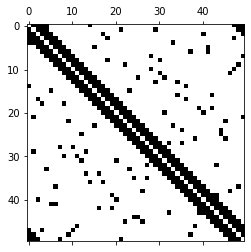

In [4]:
BN = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
A = BN.A.todense()
plt.spy(A)

In [5]:
threshold = 0.13

neurons_1 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_1)

old_settings = np.seterr(all='ignore')

CPU times: user 406 ms, sys: 4.83 ms, total: 410 ms
Wall time: 444 ms


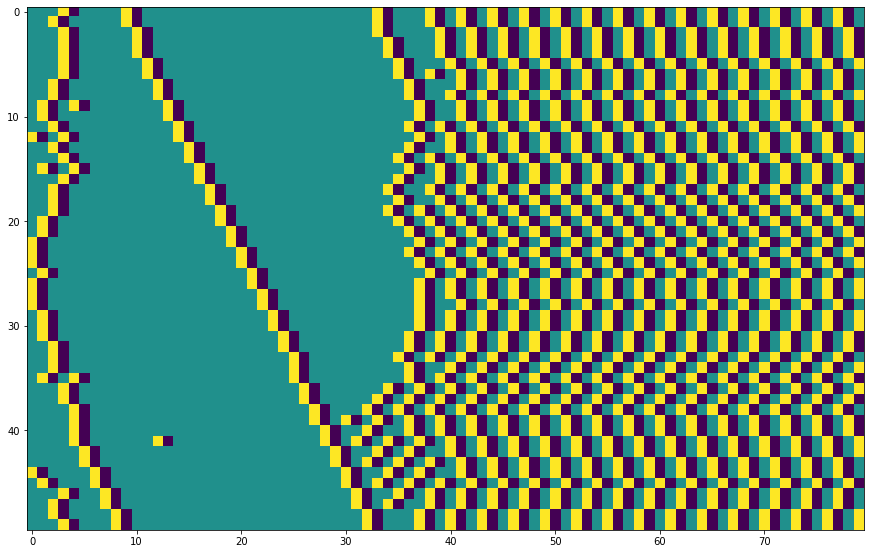

In [6]:
%%time
activation1, Q1 = BN.run_dynamic(seed, TIME, C)

fig,ax = plt.subplots(1,1, figsize = (15,10))
ax.imshow(BN.stack_histories(TIME))
#ax.imshow(BN.dynamic.todense())

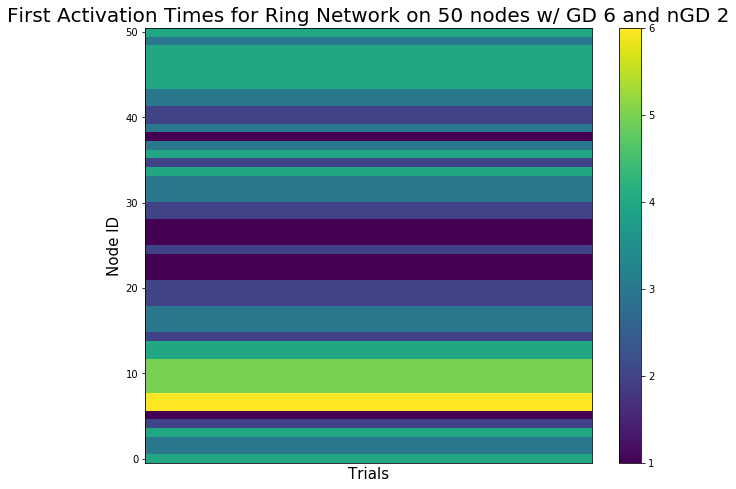

In [7]:
fig,ax = plt.subplots(1,1,figsize = (10,8))
        
pos = ax.imshow(np.array([activation1]).T, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,0.5,-0.5,BN.N+0.5])
ax.set_title('First Activation Times for %s'%BN.text, fontsize = 20)
ax.set_xlabel('Trials', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)
ax.set_xticks([i for i in range(1,2)])
        
fig.colorbar(pos, ax = ax)

In [8]:
threshold = 0.22
neurons_2 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_2)

CPU times: user 630 ms, sys: 8.08 ms, total: 638 ms
Wall time: 668 ms


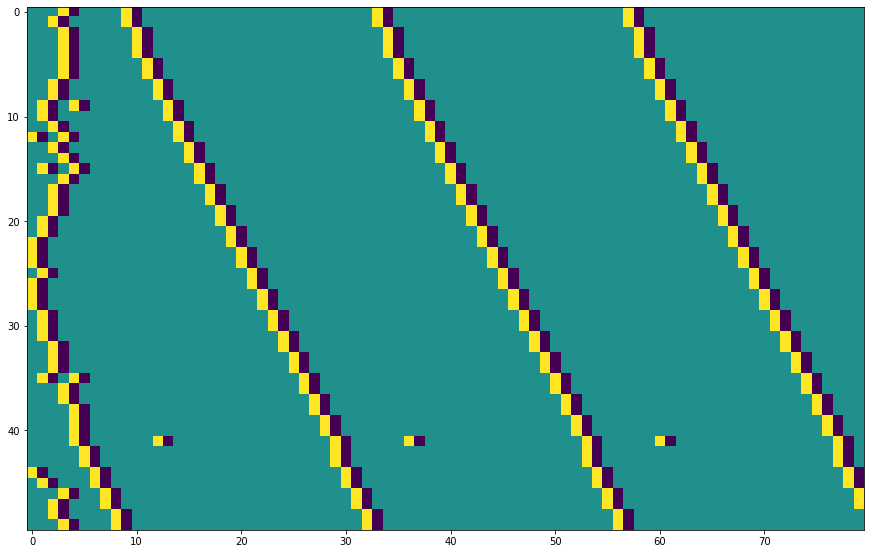

In [9]:
%%time
activation2, Q2 = BN.run_dynamic(seed, TIME, C)

fig,ax = plt.subplots(1,1, figsize = (15,10))
ax.imshow(BN.stack_histories(TIME))

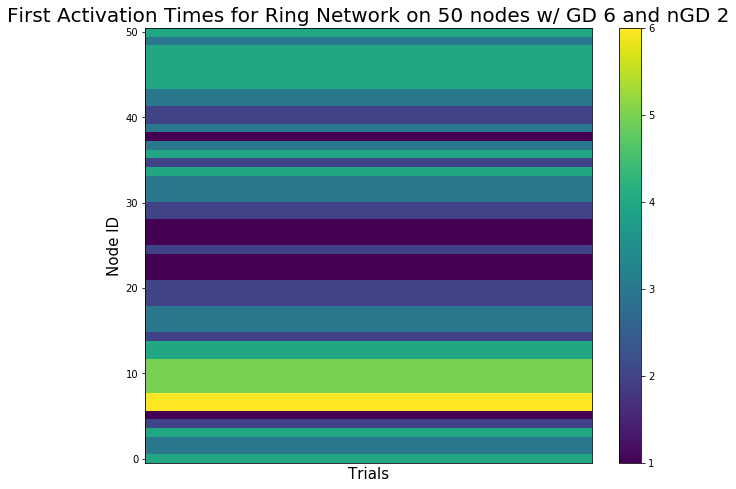

In [10]:
fig,ax = plt.subplots(1,1,figsize = (10,8))
        
pos = ax.imshow(np.array([activation2]).T, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,0.5,-0.5,BN.N+0.5])
ax.set_title('First Activation Times for %s'%BN.text, fontsize = 20)
ax.set_xlabel('Trials', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)
ax.set_xticks([i for i in range(1,2)])
        
fig.colorbar(pos, ax = ax)

In [11]:
threshold = 0.3
neurons_3 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_3)

CPU times: user 46.8 ms, sys: 3.93 ms, total: 50.7 ms
Wall time: 71.5 ms


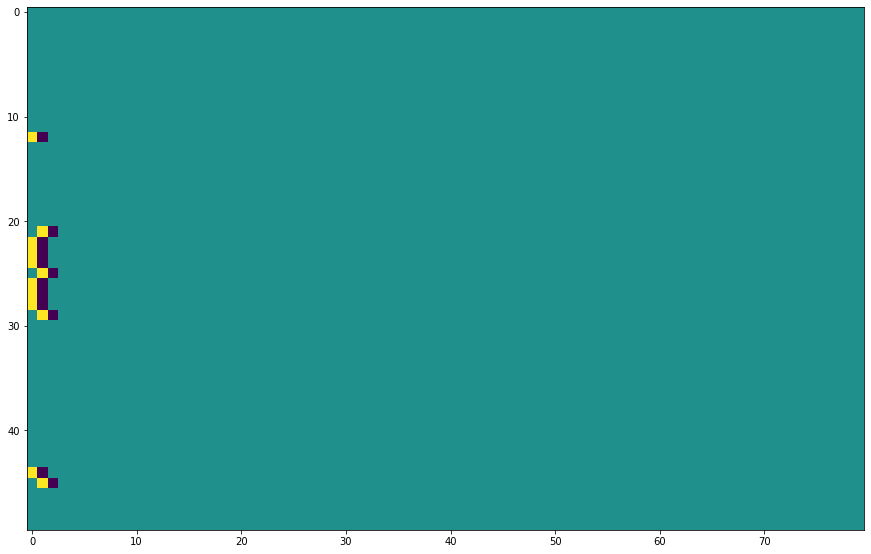

In [12]:
%%time
activation3, Q3 = BN.run_dynamic(seed, TIME, C)

fig,ax = plt.subplots(1,1, figsize = (15,10))
ax.imshow(BN.stack_histories(TIME))

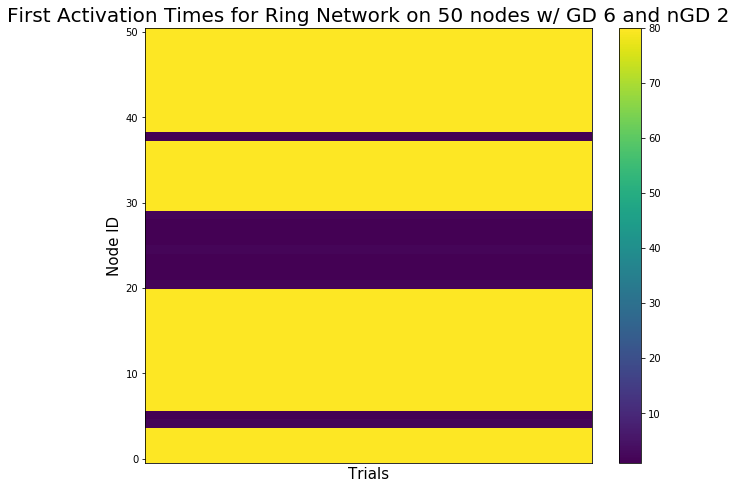

In [13]:
fig,ax = plt.subplots(1,1,figsize = (10,8))
        
pos = ax.imshow(np.array([activation3]).T, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,0.5,-0.5,BN.N+0.5])
ax.set_title('First Activation Times for %s'%BN.text, fontsize = 20)
ax.set_xlabel('Trials', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)
ax.set_xticks([i for i in range(1,2)])
        
fig.colorbar(pos, ax = ax)

In [14]:
memory = TIME
rest = 0
threshold = 0.8
neurons_4 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_4)

CPU times: user 79.6 ms, sys: 5.07 ms, total: 84.7 ms
Wall time: 86.5 ms


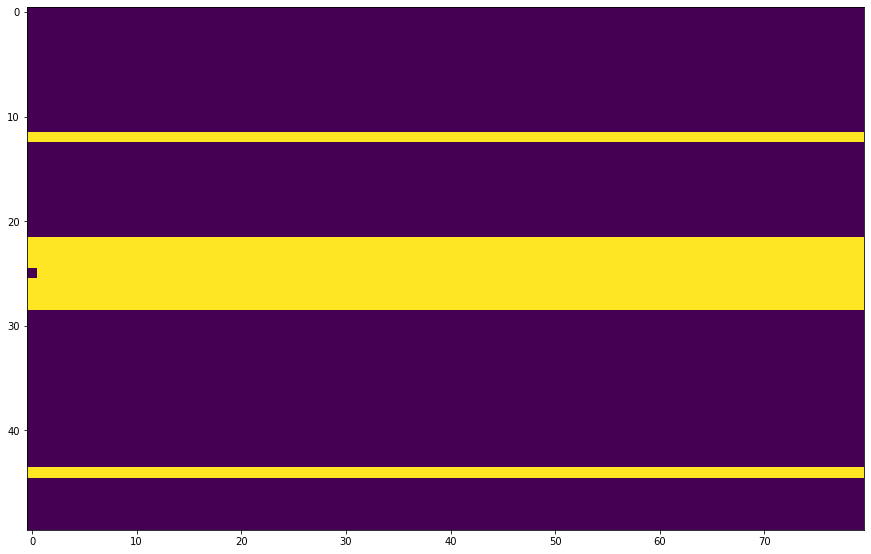

In [15]:
%%time
activation4, Q4 = BN.run_dynamic(seed, TIME, C)

fig,ax = plt.subplots(1,1, figsize = (15,10))
ax.imshow(BN.stack_histories(TIME))

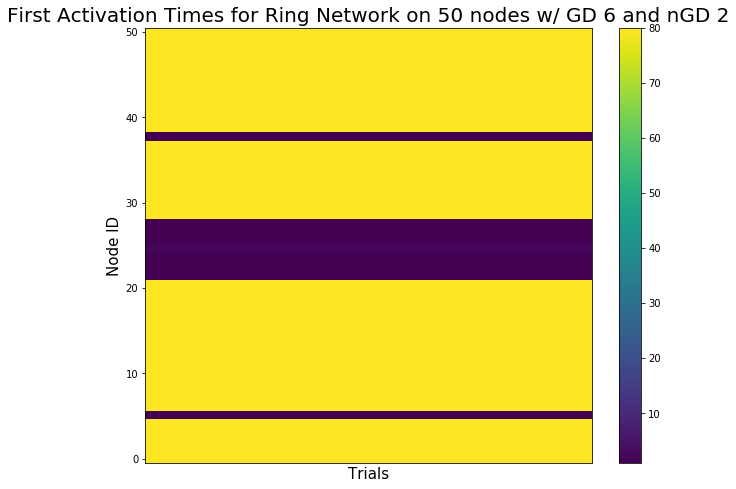

In [16]:
fig,ax = plt.subplots(1,1,figsize = (10,8))
        
pos = ax.imshow(np.array([activation4]).T, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,0.5,-0.5,BN.N+0.5])
ax.set_title('First Activation Times for %s'%BN.text, fontsize = 20)
ax.set_xlabel('Trials', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)
ax.set_xticks([i for i in range(1,2)])
        
fig.colorbar(pos, ax = ax)

In [17]:
threshold = 0.5
neurons_5 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_5)

CPU times: user 140 ms, sys: 5.32 ms, total: 145 ms
Wall time: 161 ms


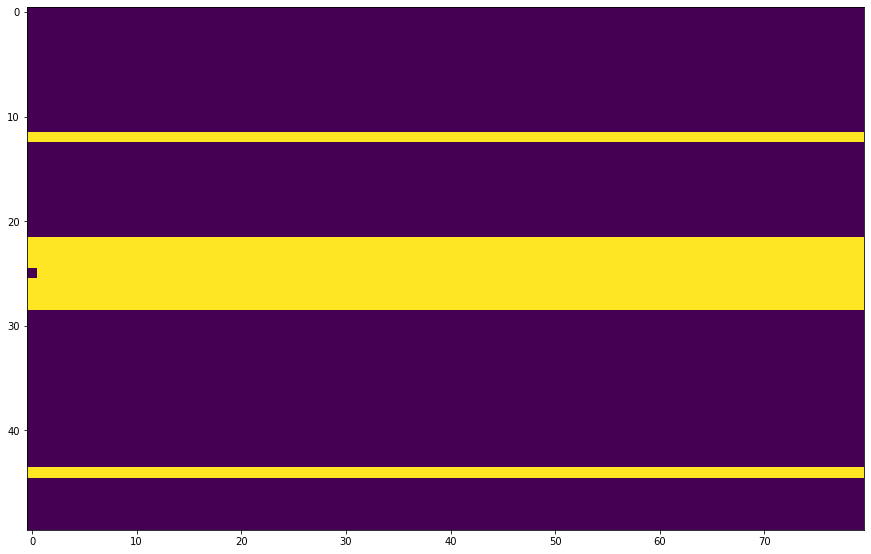

In [18]:
%%time
activation5, Q5 = BN.run_dynamic(seed, TIME, C)

fig,ax = plt.subplots(1,1, figsize = (15,10))
ax.imshow(BN.stack_histories(TIME))

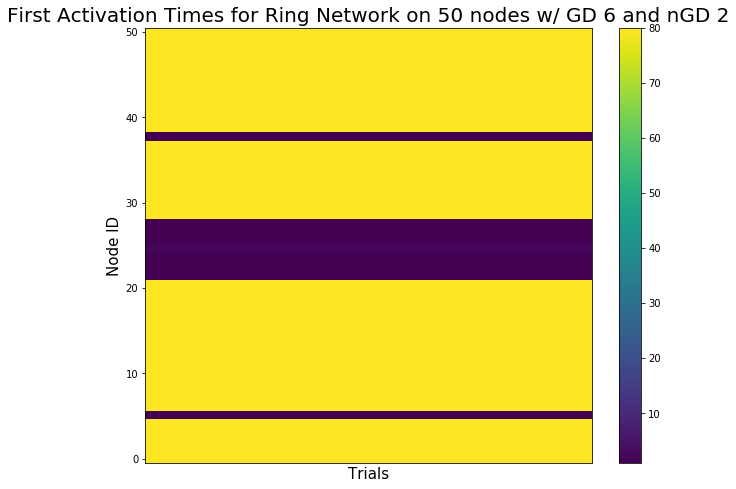

In [19]:
fig,ax = plt.subplots(1,1,figsize = (10,8))
        
pos = ax.imshow(np.array([activation5]).T, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,0.5,-0.5,BN.N+0.5])
ax.set_title('First Activation Times for %s'%BN.text, fontsize = 20)
ax.set_xlabel('Trials', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)
ax.set_xticks([i for i in range(1,2)])
        
fig.colorbar(pos, ax = ax)

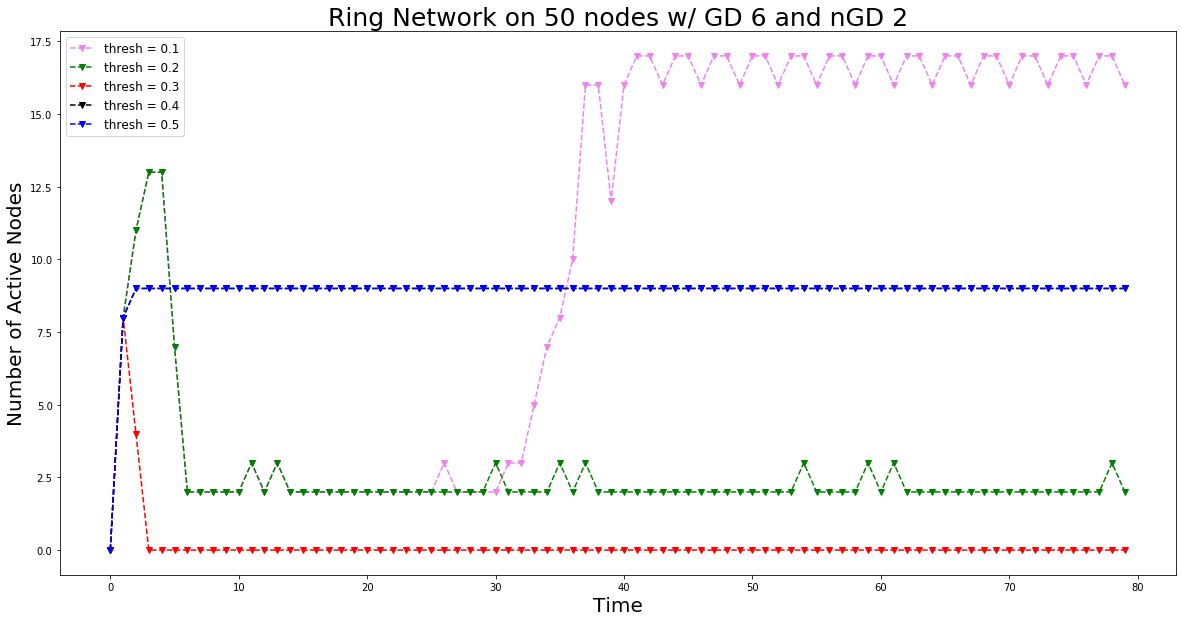

In [20]:
Q = [Q1,Q2,Q3,Q4,Q5]
labels = ['thresh = 0.1', 'thresh = 0.2', 'thresh = 0.3', 'thresh = 0.4', 'thresh = 0.5']
BN.display_comm_sizes(Q,labels)

## Run a full experiment on a Ring

In [21]:
size = 100
GD = 6
nGD = 0
topology = 'Ring'

TIME = 1000
trials = 1
C = 1000

memory = TIME
rest = 0

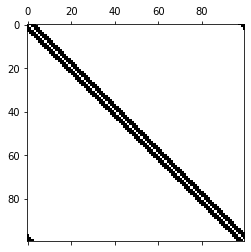

In [22]:
GBN = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
Adjacency = GBN.A.todense()
plt.spy(Adjacency)

In [23]:
threshold = 0.8
neurons = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

GBN.get_neurons(neurons)

old_settings = np.seterr(all='ignore')

In [24]:
%%time
FAT, QS = GBN.make_distance_matrix(TIME, C, trials)

CPU times: user 12.3 s, sys: 83.4 ms, total: 12.4 s
Wall time: 13.2 s


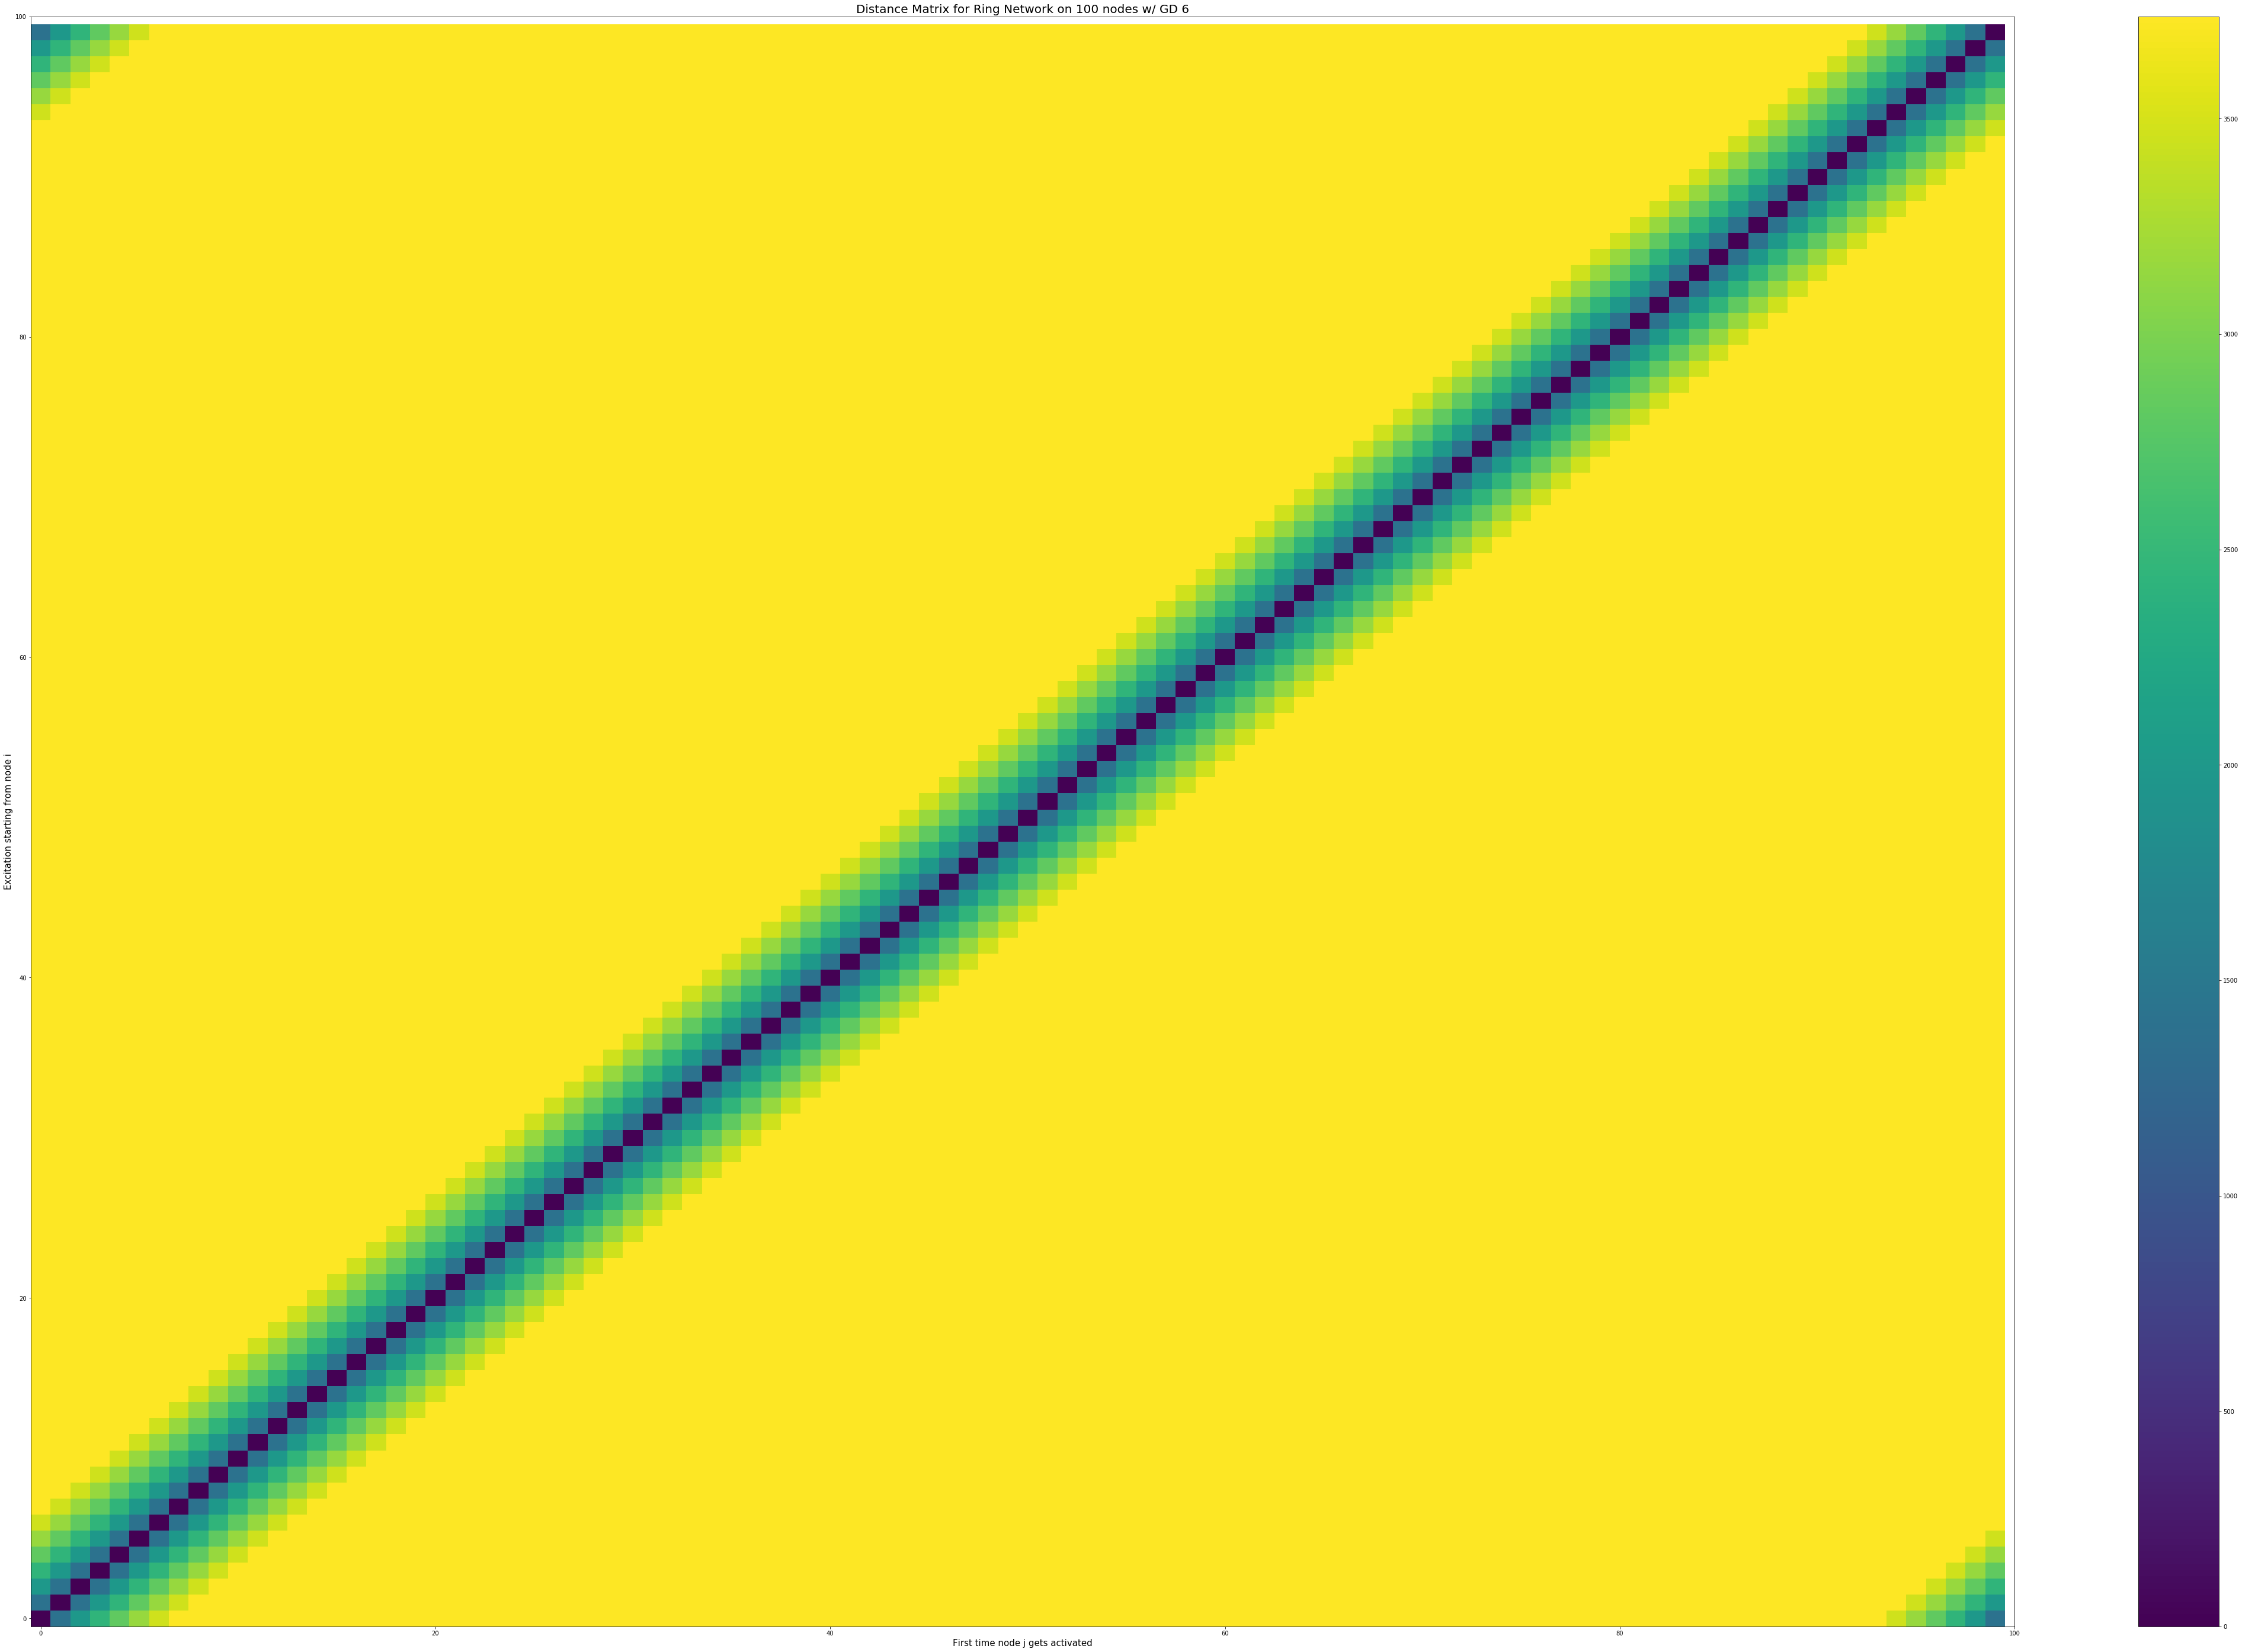

In [25]:
GBN.spy_distance_matrix(FAT)

Deprecated parameter. It has been replaced by max_intervals


(0.6219813040961558, 0.0)

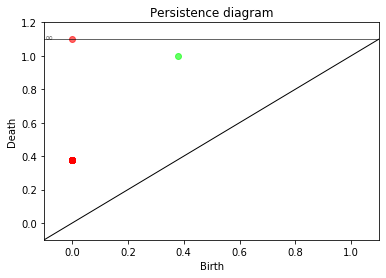

In [26]:
GBN.compute_persistence(FAT, spy = True)

## Run on a sphere

In [27]:
size = 50
GD = 6
nGD = 0
topology = 'Sphere'

seed = 25
TIME = 80
trials = 1
C = 1000

memory = TIME
rest = 0

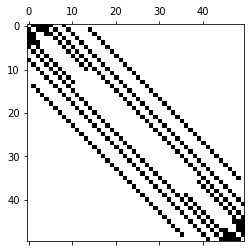

In [28]:
BN = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
A = BN.A.todense()
plt.spy(A)

In [29]:
threshold = 0.33

neurons_1 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_1)

CPU times: user 48.8 ms, sys: 3.93 ms, total: 52.7 ms
Wall time: 49.8 ms


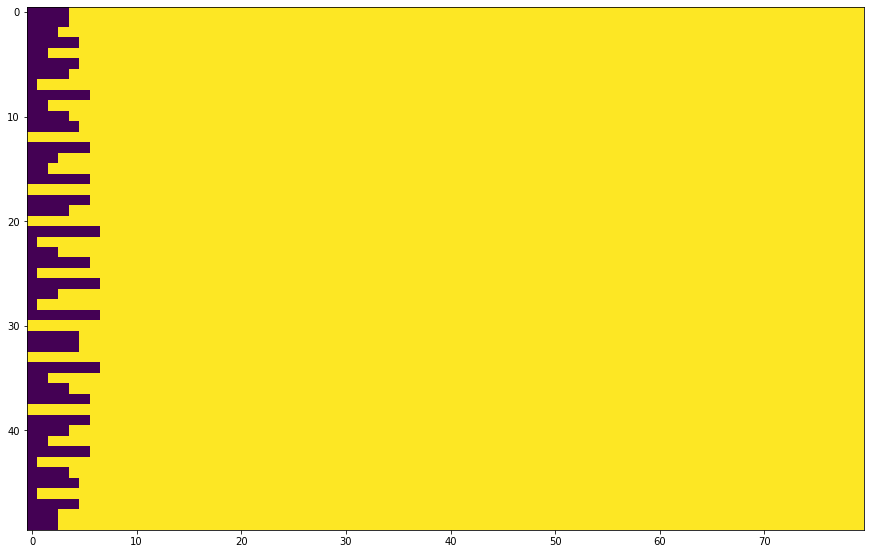

In [30]:
%%time
activation1, Q1 = BN.run_dynamic(seed, TIME, C)

fig,ax = plt.subplots(1,1, figsize = (15,10))
ax.imshow(BN.stack_histories(TIME))

In [31]:
%%time
FAT_sphere, QS_sphere = BN.make_distance_matrix(TIME, C, trials)

CPU times: user 1.15 s, sys: 12 ms, total: 1.16 s
Wall time: 1.19 s


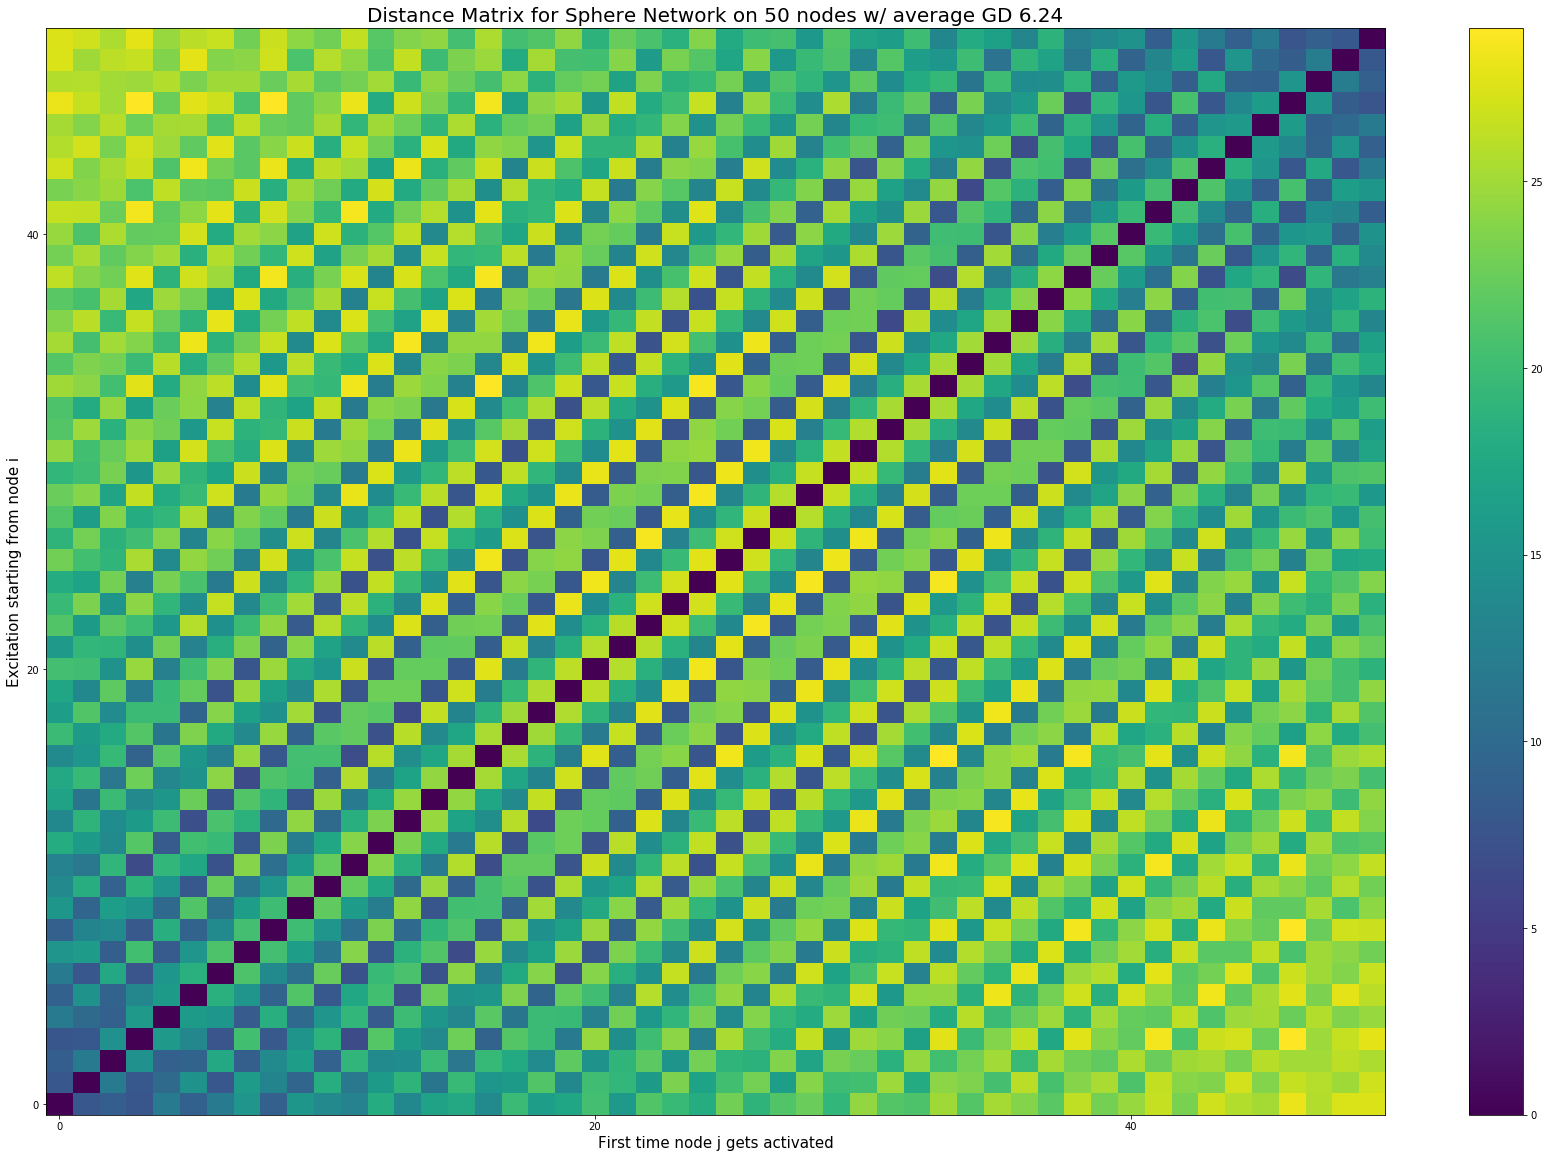

In [32]:
BN.spy_distance_matrix(FAT_sphere)

Deprecated parameter. It has been replaced by max_intervals


(0.3976735660369136, 0.0)

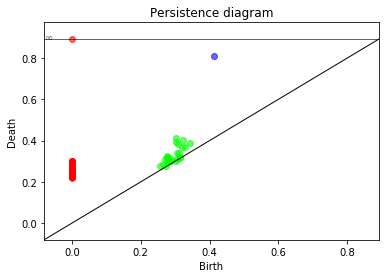

In [33]:
BN.compute_persistence(FAT_sphere, dimension = 3, spy = True)

## Run on a Torus

In [34]:
size = 100
GD = 6
nGD = 0
topology = 'Torus'

seed = 25
TIME = 80
trials = 1
C = 1000

memory = TIME
rest = 0

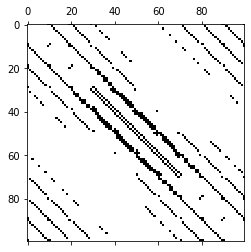

In [35]:
BN = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
A = BN.A.todense()
plt.spy(A)

In [36]:
threshold = 0.1

neurons_1 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_1)

CPU times: user 96.4 ms, sys: 3.22 ms, total: 99.7 ms
Wall time: 102 ms


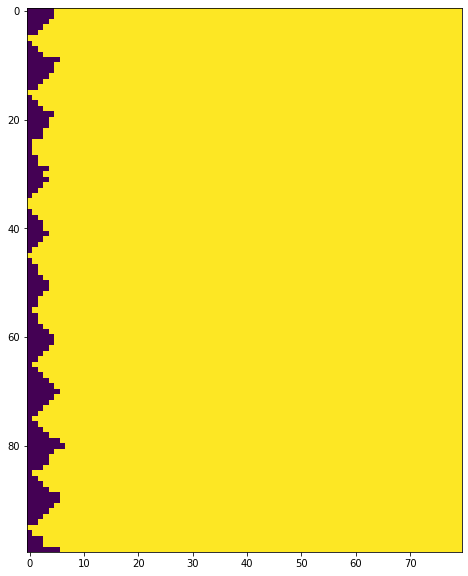

In [37]:
%%time
activation1, Q1 = BN.run_dynamic(seed, TIME, C)

fig,ax = plt.subplots(1,1, figsize = (15,10))
ax.imshow(BN.stack_histories(TIME))

In [38]:
%%time
FAT_torus, QS_torus = BN.make_distance_matrix(TIME, C, trials)

CPU times: user 7.89 s, sys: 75.8 ms, total: 7.97 s
Wall time: 8.39 s


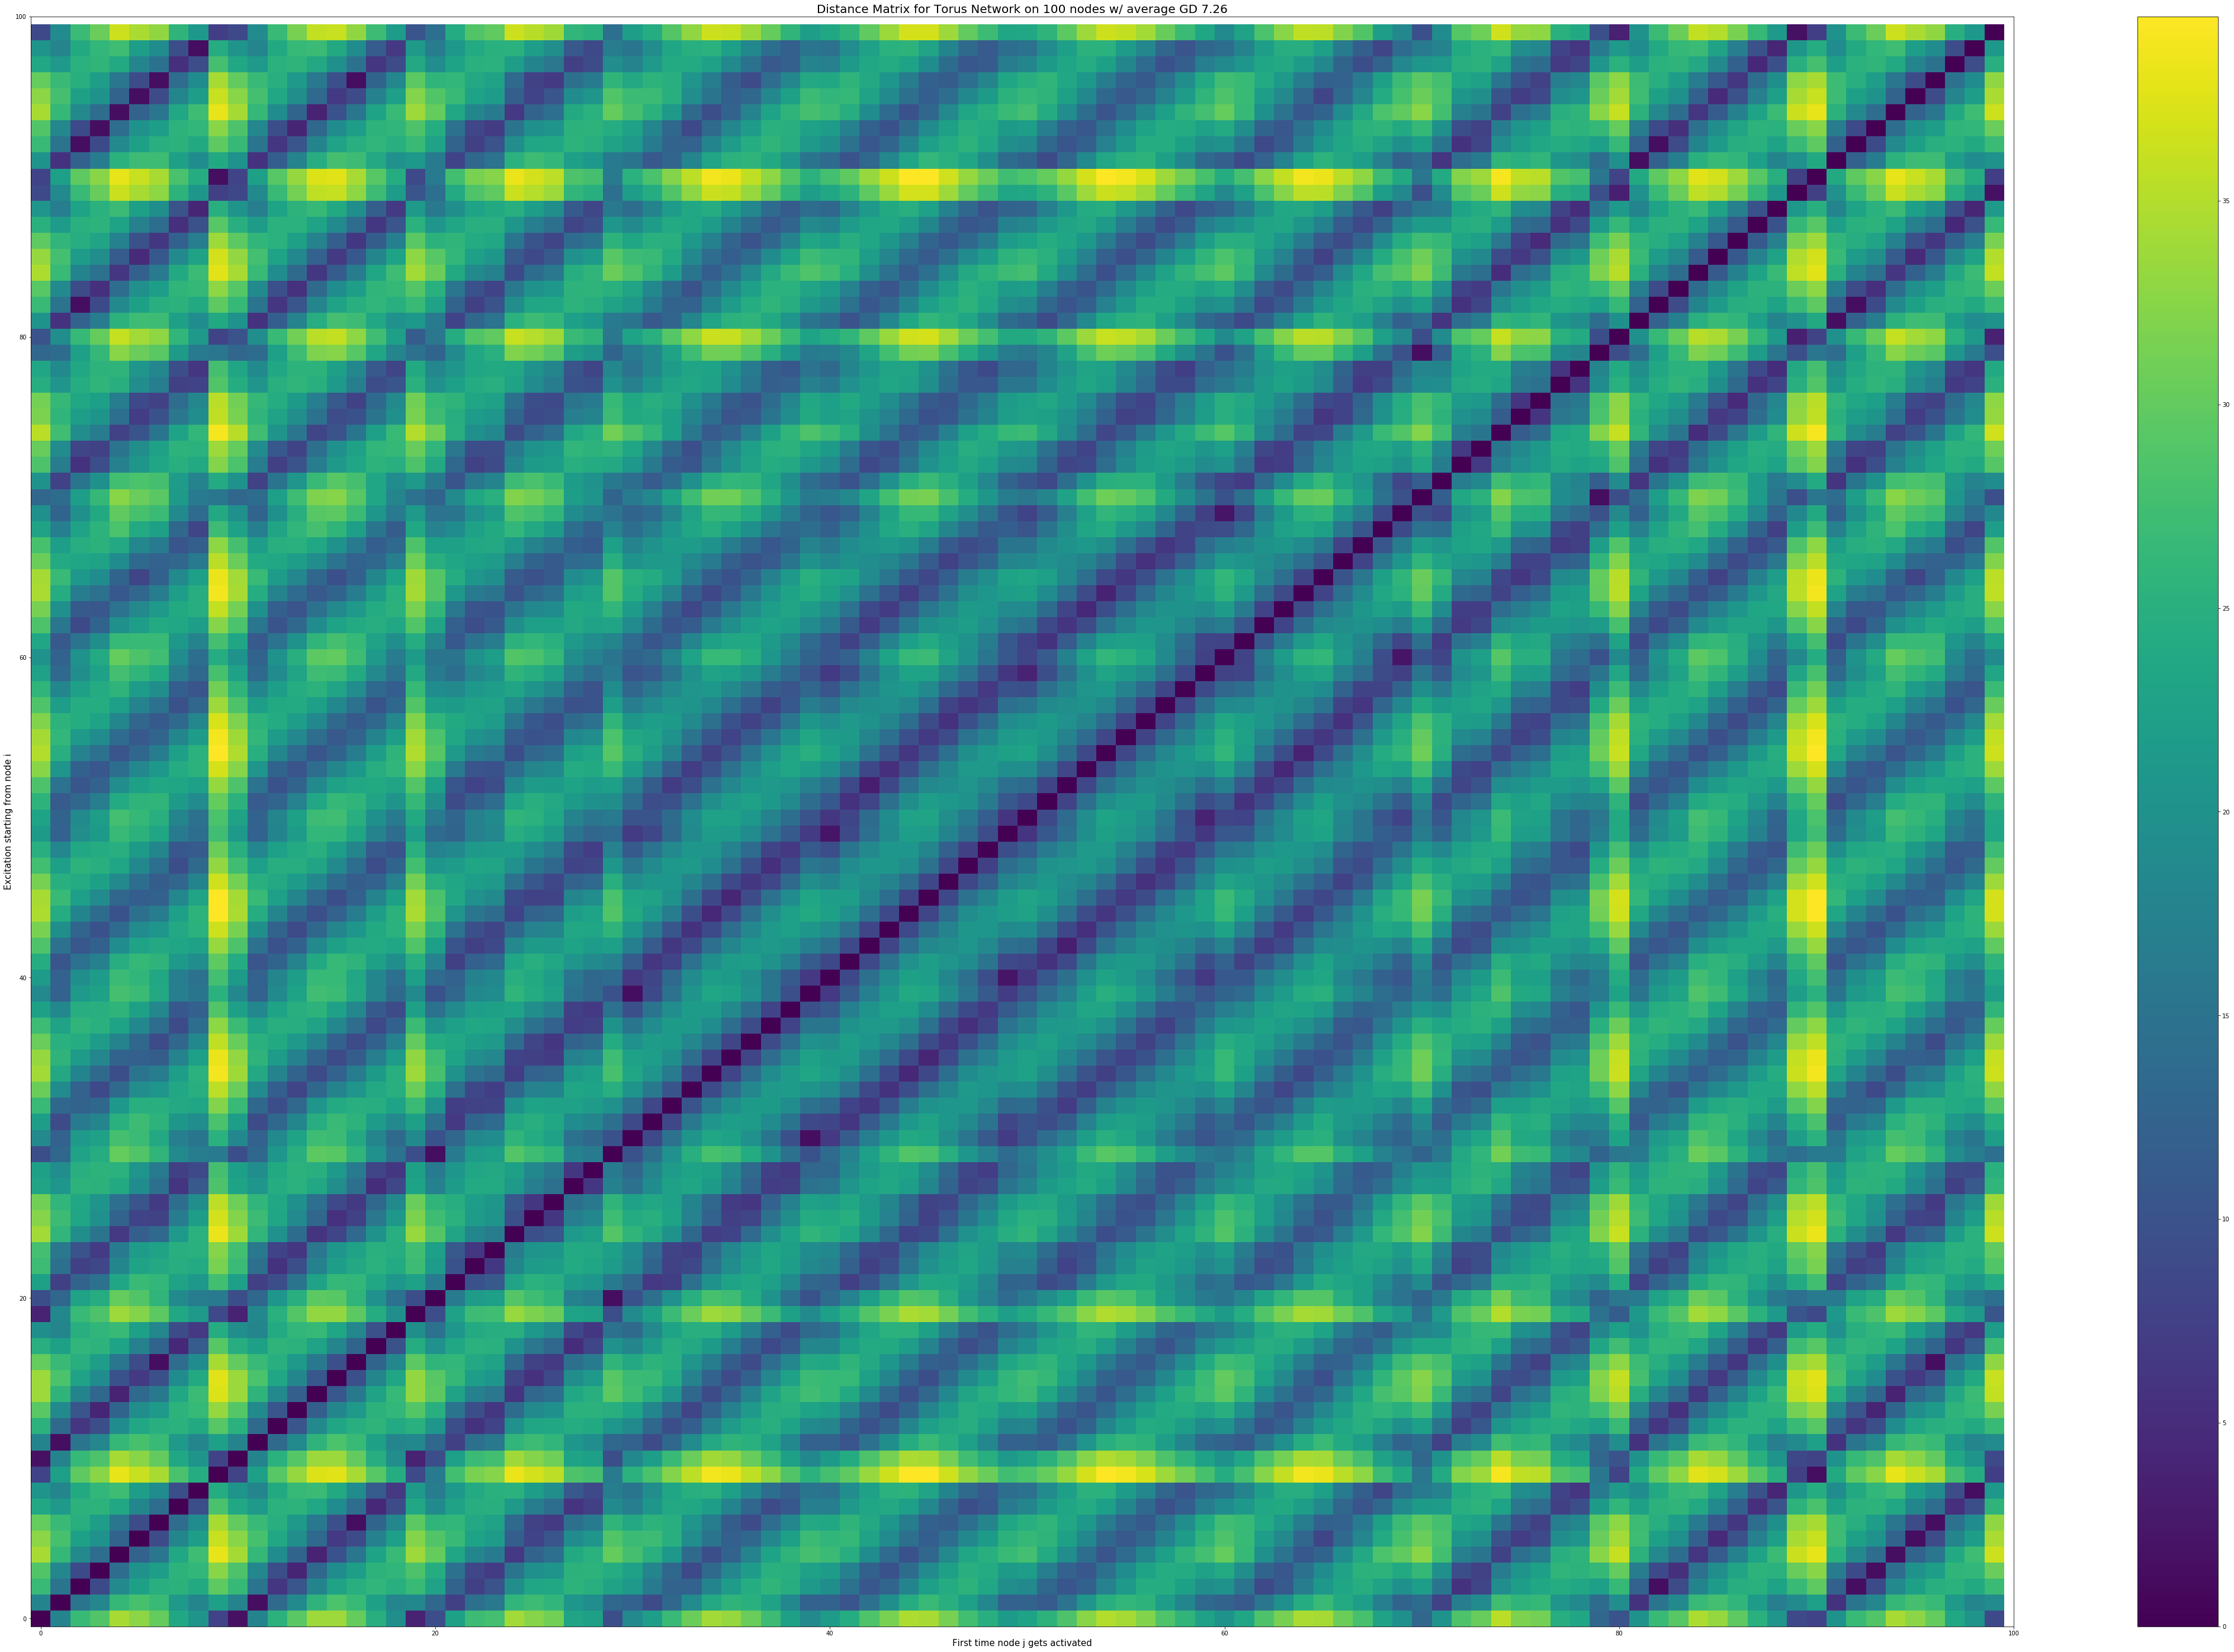

In [39]:
BN.spy_distance_matrix(FAT_torus)

Deprecated parameter. It has been replaced by max_intervals


(0.01869580221788053, 0.03206263310870722)

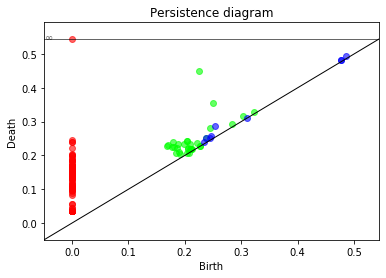

In [40]:
BN.compute_persistence(FAT_torus, dimension = 3, spy = True)